In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [6]:
import asyncio
from itertools import cycle, islice
from lib import models
from lib.grpo import GRPO
from lib.pack import packed_tensors_from_tokenized_results, plot_packed_tensors
from lib.recipe import ComponentConfig, TuneRecipeConfig
from lib.tasks import ChatCompletionParams, get_task_results
from lib.temporal_clue import get_temporal_clue_tasks
from lib.tokenize import TaskResultTokenizer
from lib.tune import clear_iteration_dirs, get_iteration, get_last_iteration_dir, last_tune_log, tune, Verbosity
from lib.utils import symlink_shm, rsync_dir
from lib.vllm import start_vllm, kill_vllm_workers
import polars as pl
import random
import torch
from transformers import AutoTokenizer
import wandb

run_name = "030"
run = wandb.init(
    project="rl-experiments",
    name=run_name,
    id=run_name,
    resume="allow",
    config={"task": "temporal-clue"},
)

tasks = list(get_temporal_clue_tasks())
val_tasks = tasks[:64]
test_tasks = tasks[64:128]
train_tasks = tasks[128:]
random.seed(42)
random.shuffle(train_tasks)
len(val_tasks), len(test_tasks), len(train_tasks)

(64, 64, 2860)

In [8]:
# GRPO params
wandb.config["clip_epsilon"] = clip_epsilon = 0.2
wandb.config["entropy_coef"] = entropy_coef = 0.02
wandb.config["kl_coef"] = kl_coef = 0.0
wandb.config["tanh"] = tanh = True

expected_tokens = 950  # Expected completion tokens per task sample
wandb.config["lr"] = lr = 2e-6
wandb.config["betas"] = betas = (0.9, 0.999)  # (0.9, 0.99)
wandb.config["weight_decay"] = weight_decay = 0.01  # 0.1
model = models.qwen_14b()
wandb.config["model"] = model.base_model
num_iterations = 1_000
output_dir = f"./models/{run_name}"
wandb.config["samples_per_task"] = samples_per_task = 50
wandb.config["seq_len"] = seq_len = 16384
wandb.config["stride"] = stride = 32
wandb.config["tasks_per_iter"] = tasks_per_iter = 64
sync_dir = symlink_shm(output_dir) or output_dir
tokenizer = AutoTokenizer.from_pretrained(model.base_model)
verbosity: Verbosity = 2

In [8]:
print(tokenizer.get_chat_template())

{%- if tools %}
    {{- '<|im_start|>system\n' }}
    {%- if messages[0]['role'] == 'system' %}
        {{- messages[0]['content'] }}
    {%- else %}
        {{- 'You are Qwen, created by Alibaba Cloud. You are a helpful assistant.' }}
    {%- endif %}
    {{- "\n\n# Tools\n\nYou may call one or more functions to assist with the user query.\n\nYou are provided with function signatures within <tools></tools> XML tags:\n<tools>" }}
    {%- for tool in tools %}
        {{- "\n" }}
        {{- tool | tojson }}
    {%- endfor %}
    {{- "\n</tools>\n\nFor each function call, return a json object with function name and arguments within <tool_call></tool_call> XML tags:\n<tool_call>\n{\"name\": <function-name>, \"arguments\": <args-json-object>}\n</tool_call><|im_end|>\n" }}
{%- else %}
    {%- if messages[0]['role'] == 'system' %}
        {{- '<|im_start|>system\n' + messages[0]['content'] + '<|im_end|>\n' }}
    {%- else %}
        {{- '<|im_start|>system\nYou are Qwen, created by Alibaba C

In [17]:
"{%- if (message.role == \"user\") or (message.role == \"system\" and not loop.first) or (message.role == \"assistant\" and not message.tool_calls) %}\n        {{- '<|im_start|>' + message.role + '\\n' + message.content + '<|im_end|>' + '\\n' }}" in tokenizer.get_chat_template()

True

In [23]:
print(
    tokenizer.get_chat_template()
    .replace(
        """
    {%- if (message.role == "user") or (message.role == "system" and not loop.first) or (message.role == "assistant" and not message.tool_calls) %}
        {{- '<|im_start|>' + message.role + '\\n' + message.content + '<|im_end|>' + '\\n' }}
    """.strip(),
        """
    {%- if (message.role == "user") or (message.role == "system" and not loop.first) %}
        {{- '<|im_start|>' + message.role + '\\n' + message.content + '<|im_end|>' + '\\n' }}
    {%- elif message.role == "assistant" and not message.tool_calls %}
        {{- '<|im_start|>' + message.role + '\\n' }}{% generation %}{{ message.content }}{% endgeneration %}{{ '<|im_end|>' + '\\n' }}
""".strip(),
    )
    .replace(
        """
        {%- elif message.role == "assistant" %}
        {{- '<|im_start|>' + message.role }}
        {%- if message.content %}
            {{- '\\n' + message.content }}
        {%- endif %}""".strip(),
        """
        {%- elif message.role == "assistant" %}
        {{- '<|im_start|>' + message.role }}
        {%- if message.content %}
            {{- '\\n' }}{% generation %}{{ message.content }}{% endgeneration %}
        {%- endif %}""".strip(),
    )
)

{%- if tools %}
    {{- '<|im_start|>system\n' }}
    {%- if messages[0]['role'] == 'system' %}
        {{- messages[0]['content'] }}
    {%- else %}
        {{- 'You are Qwen, created by Alibaba Cloud. You are a helpful assistant.' }}
    {%- endif %}
    {{- "\n\n# Tools\n\nYou may call one or more functions to assist with the user query.\n\nYou are provided with function signatures within <tools></tools> XML tags:\n<tools>" }}
    {%- for tool in tools %}
        {{- "\n" }}
        {{- tool | tojson }}
    {%- endfor %}
    {{- "\n</tools>\n\nFor each function call, return a json object with function name and arguments within <tool_call></tool_call> XML tags:\n<tool_call>\n{\"name\": <function-name>, \"arguments\": <args-json-object>}\n</tool_call><|im_end|>\n" }}
{%- else %}
    {%- if messages[0]['role'] == 'system' %}
        {{- '<|im_start|>system\n' + messages[0]['content'] + '<|im_end|>\n' }}
    {%- else %}
        {{- '<|im_start|>system\nYou are Qwen, created by Alibaba C

In [9]:
"""
{%- if tools %}
    {{- '<|im_start|>system\n' }}
    {%- if messages[0]['role'] == 'system' %}
        {{- messages[0]['content'] }}
    {%- else %}
        {{- 'You are Qwen, created by Alibaba Cloud. You are a helpful assistant.' }}
    {%- endif %}
    {{- "\n\n# Tools\n\nYou may call one or more functions to assist with the user query.\n\nYou are provided with function signatures within <tools></tools> XML tags:\n<tools>" }}
    {%- for tool in tools %}
        {{- "\n" }}
        {{- tool | tojson }}
    {%- endfor %}
    {{- "\n</tools>\n\nFor each function call, return a json object with function name and arguments within <tool_call></tool_call> XML tags:\n<tool_call>\n{\"name\": <function-name>, \"arguments\": <args-json-object>}\n</tool_call><|im_end|>\n" }}
{%- else %}
    {%- if messages[0]['role'] == 'system' %}
        {{- '<|im_start|>system\n' + messages[0]['content'] + '<|im_end|>\n' }}
    {%- else %}
        {{- '<|im_start|>system\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>\n' }}
    {%- endif %}
{%- endif %}
{%- for message in messages %}
    {%- if (message.role == "user") or (message.role == "system" and not loop.first) or (message.role == "assistant" and not message.tool_calls) %}
        {{- '<|im_start|>' + message.role + '\n' + message.content + '<|im_end|>' + '\n' }}
    {%- elif message.role == "assistant" %}
        {{- '<|im_start|>' + message.role }}
        {%- if message.content %}
            {{- '\n' + message.content }}
        {%- endif %}
        {%- for tool_call in message.tool_calls %}
            {%- if tool_call.function is defined %}
                {%- set tool_call = tool_call.function %}
            {%- endif %}
            {{- '\n<tool_call>\n{"name": "' }}
            {{- tool_call.name }}
            {{- '", "arguments": ' }}
            {{- tool_call.arguments | tojson }}
            {{- '}\n</tool_call>' }}
        {%- endfor %}
        {{- '<|im_end|>\n' }}
    {%- elif message.role == "tool" %}
        {%- if (loop.index0 == 0) or (messages[loop.index0 - 1].role != "tool") %}
            {{- '<|im_start|>user' }}
        {%- endif %}
        {{- '\n<tool_response>\n' }}
        {{- message.content }}
        {{- '\n</tool_response>' }}
        {%- if loop.last or (messages[loop.index0 + 1].role != "tool") %}
            {{- '<|im_end|>\n' }}
        {%- endif %}
    {%- endif %}
{%- endfor %}
{%- if add_generation_prompt %}
    {{- '<|im_start|>assistant\n' }}
{%- endif %}
"""

SyntaxError: invalid syntax (2708997390.py, line 1)

$ vllm serve Qwen/Qwen2.5-14B-Instruct --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --port=8000 --api-key=default
INFO 02-21 15:12:28 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 15:12:29 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 15:12:29 api_server.py:841] args: Namespace(subparser='serve', model_tag='Qwen/Qwen2.5-14B-Instruct', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_role='assistant', ssl_keyfile=None, ssl_certfile=None, ssl_ca_certs=None, ssl_cert_reqs=0, root_

Loading safetensors checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  12% Completed | 1/8 [00:00<00:04,  1.58it/s]
Loading safetensors checkpoint shards:  25% Completed | 2/8 [00:01<00:03,  1.53it/s]
Loading safetensors checkpoint shards:  38% Completed | 3/8 [00:01<00:03,  1.54it/s]
Loading safetensors checkpoint shards:  50% Completed | 4/8 [00:02<00:01,  2.13it/s]
Loading safetensors checkpoint shards:  62% Completed | 5/8 [00:02<00:01,  1.94it/s]
Loading safetensors checkpoint shards:  75% Completed | 6/8 [00:03<00:01,  1.93it/s]
Loading safetensors checkpoint shards:  88% Completed | 7/8 [00:03<00:00,  1.77it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.72it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:04<00:00,  1.76it/s]



INFO 02-21 15:13:42 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=10178) INFO 02-21 15:13:43 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=10178) INFO 02-21 15:13:47 worker.py:267] Memory profiling takes 4.72 seconds
(VllmWorkerProcess pid=10178) INFO 02-21 15:13:47 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=10178) INFO 02-21 15:13:47 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-21 15:13:48 worker.py:267] Memory profiling takes 4.75 seconds
INFO 02-21 15:13:48 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-21 15:13:48 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB; Py

INFO:     Started server process [9874]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 15:14:37 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:49534 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

val: 100%|██████████| 128/128 [10:01<00:00, 55.18s/it, completion_tokens=924, prompt_tokens=1220, reward=0.3, token_logprobs=118309]


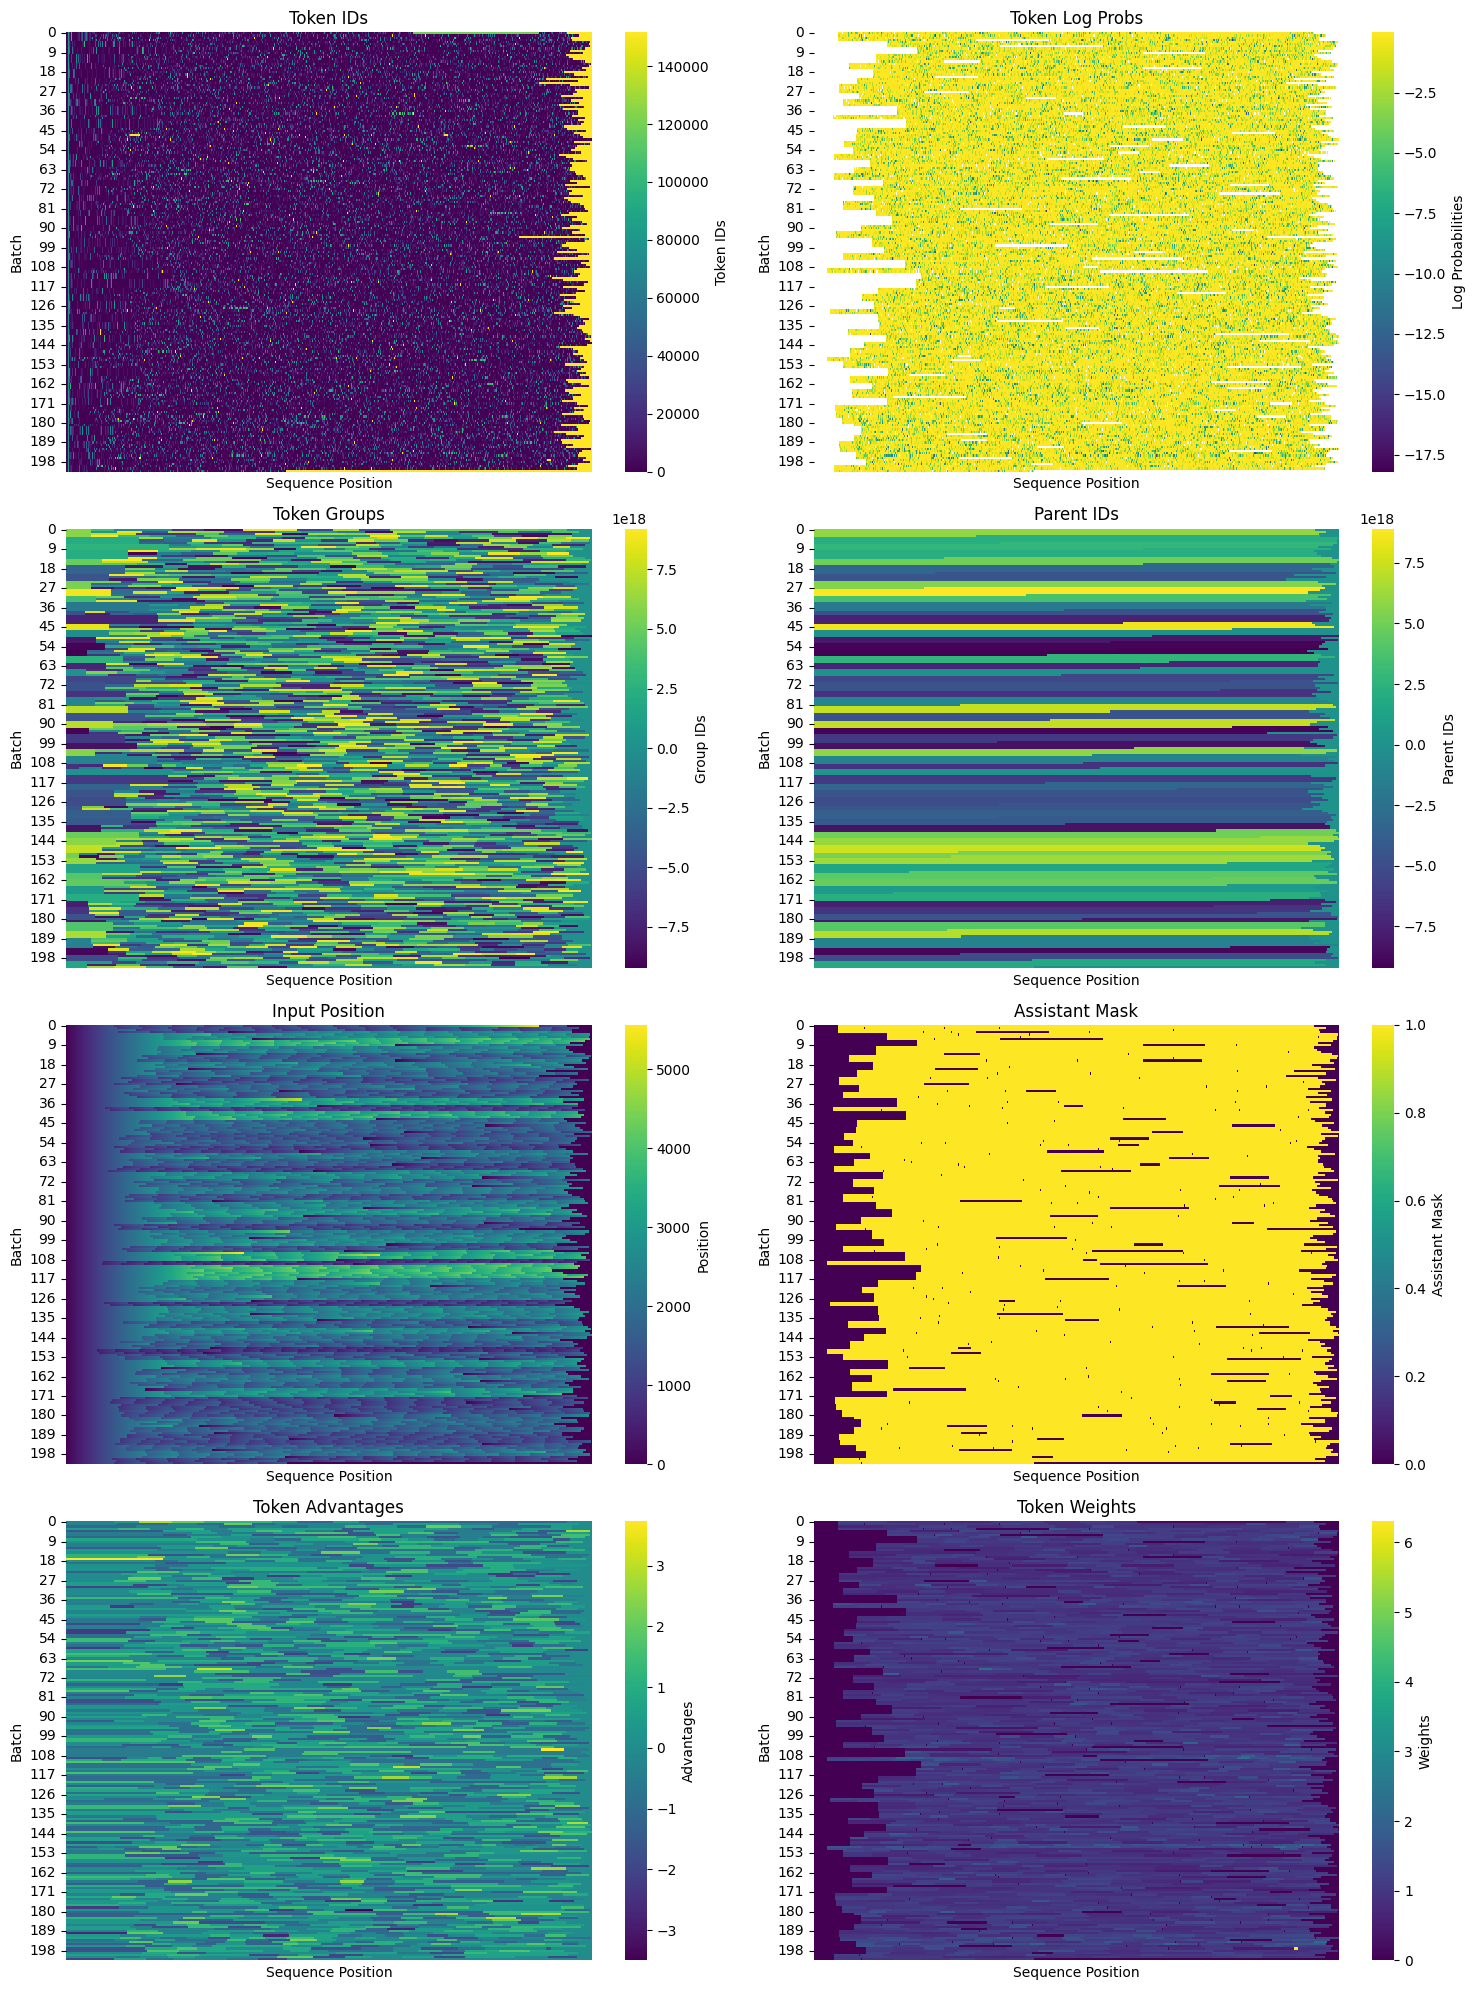

rsyncing /dev/shm/models/030 to /dev/shm/models/030
Download complete. Moving file to /home/gcpuser/.cache/huggingface/hub/models--Qwen--Qwen2.5-14B-Instruct/blobs/a6344aac8c09253b3b630fb776ae94478aa0275b
Download complete. Moving file to /home/gcpuser/.cache/huggingface/hub/models--Qwen--Qwen2.5-14B-Instruct/blobs/6634c8cc3133b3848ec74b9f275acaaa1ea618ab
Download complete. Moving file to /home/gcpuser/.cache/huggingface/hub/models--Qwen--Qwen2.5-14B-Instruct/blobs/cdb53558f3d3871db6823dd95ecac029044757a0
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/030/config.yaml
Running with torchrun...


W0221 15:25:26.761000 12706 torch/distributed/run.py:793] 
W0221 15:25:26.761000 12706 torch/distributed/run.py:793] *****************************************
W0221 15:25:26.761000 12706 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0221 15:25:26.761000 12706 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/hub/models--Qwen--Qwen2.5-14B-Instruct/snapshots/cf98f3b3bbb457ad9e2bb7baf9a0125b6b88caa8
  checkpoint_files:
  - model-00006-of-00008.safetensors
  - m

Writing logs to models/030/logs/log_1740151531.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 24.80 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|51|Loss: -0.0223: 100%|██████████| 51/51 [30:36<00:00, 35.62s/it, entropy=1.17, kl_div=nan, loss=-0.0223, policy=0.00117]   INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 17.18 secs
INFO:torchtune.utils._logging:Model checkpoint of size 3.89 GB sa

Saved iteration #1 model files to ./models/030/0001
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/030/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/030/0001 --port=8000 --api-key=default
INFO 02-21 15:57:31 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 15:57:31 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 15:57:31 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/030/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=No

Loading pt checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading pt checkpoint shards:  12% Completed | 1/8 [00:02<00:17,  2.49s/it]
Loading pt checkpoint shards:  25% Completed | 2/8 [00:05<00:15,  2.55s/it]
Loading pt checkpoint shards:  38% Completed | 3/8 [00:07<00:12,  2.57s/it]
Loading pt checkpoint shards:  50% Completed | 4/8 [00:10<00:10,  2.58s/it]
Loading pt checkpoint shards:  62% Completed | 5/8 [00:12<00:07,  2.57s/it]
Loading pt checkpoint shards:  75% Completed | 6/8 [00:15<00:05,  2.58s/it]
Loading pt checkpoint shards:  88% Completed | 7/8 [00:18<00:02,  2.58s/it]


(VllmWorkerProcess pid=16382) INFO 02-21 15:58:04 model_runner.py:1115] Loading model weights took 13.9281 GB


Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.08s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.38s/it]



INFO 02-21 15:58:05 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=16382) INFO 02-21 15:58:07 worker.py:267] Memory profiling takes 2.15 seconds
(VllmWorkerProcess pid=16382) INFO 02-21 15:58:07 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=16382) INFO 02-21 15:58:07 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-21 15:58:07 worker.py:267] Memory profiling takes 2.27 seconds
INFO 02-21 15:58:07 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-21 15:58:07 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB; PyTorch activation peak memory takes 5.70GiB; the rest of the memory reserved for KV Cache is 53.71GiB.
INFO 02-

INFO:     Started server process [16096]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 15:58:55 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:49448 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [05:48<00:00,  1.95it/s, completion_tokens=672, prompt_tokens=1334, reward=0.296, token_logprobs=2150383]


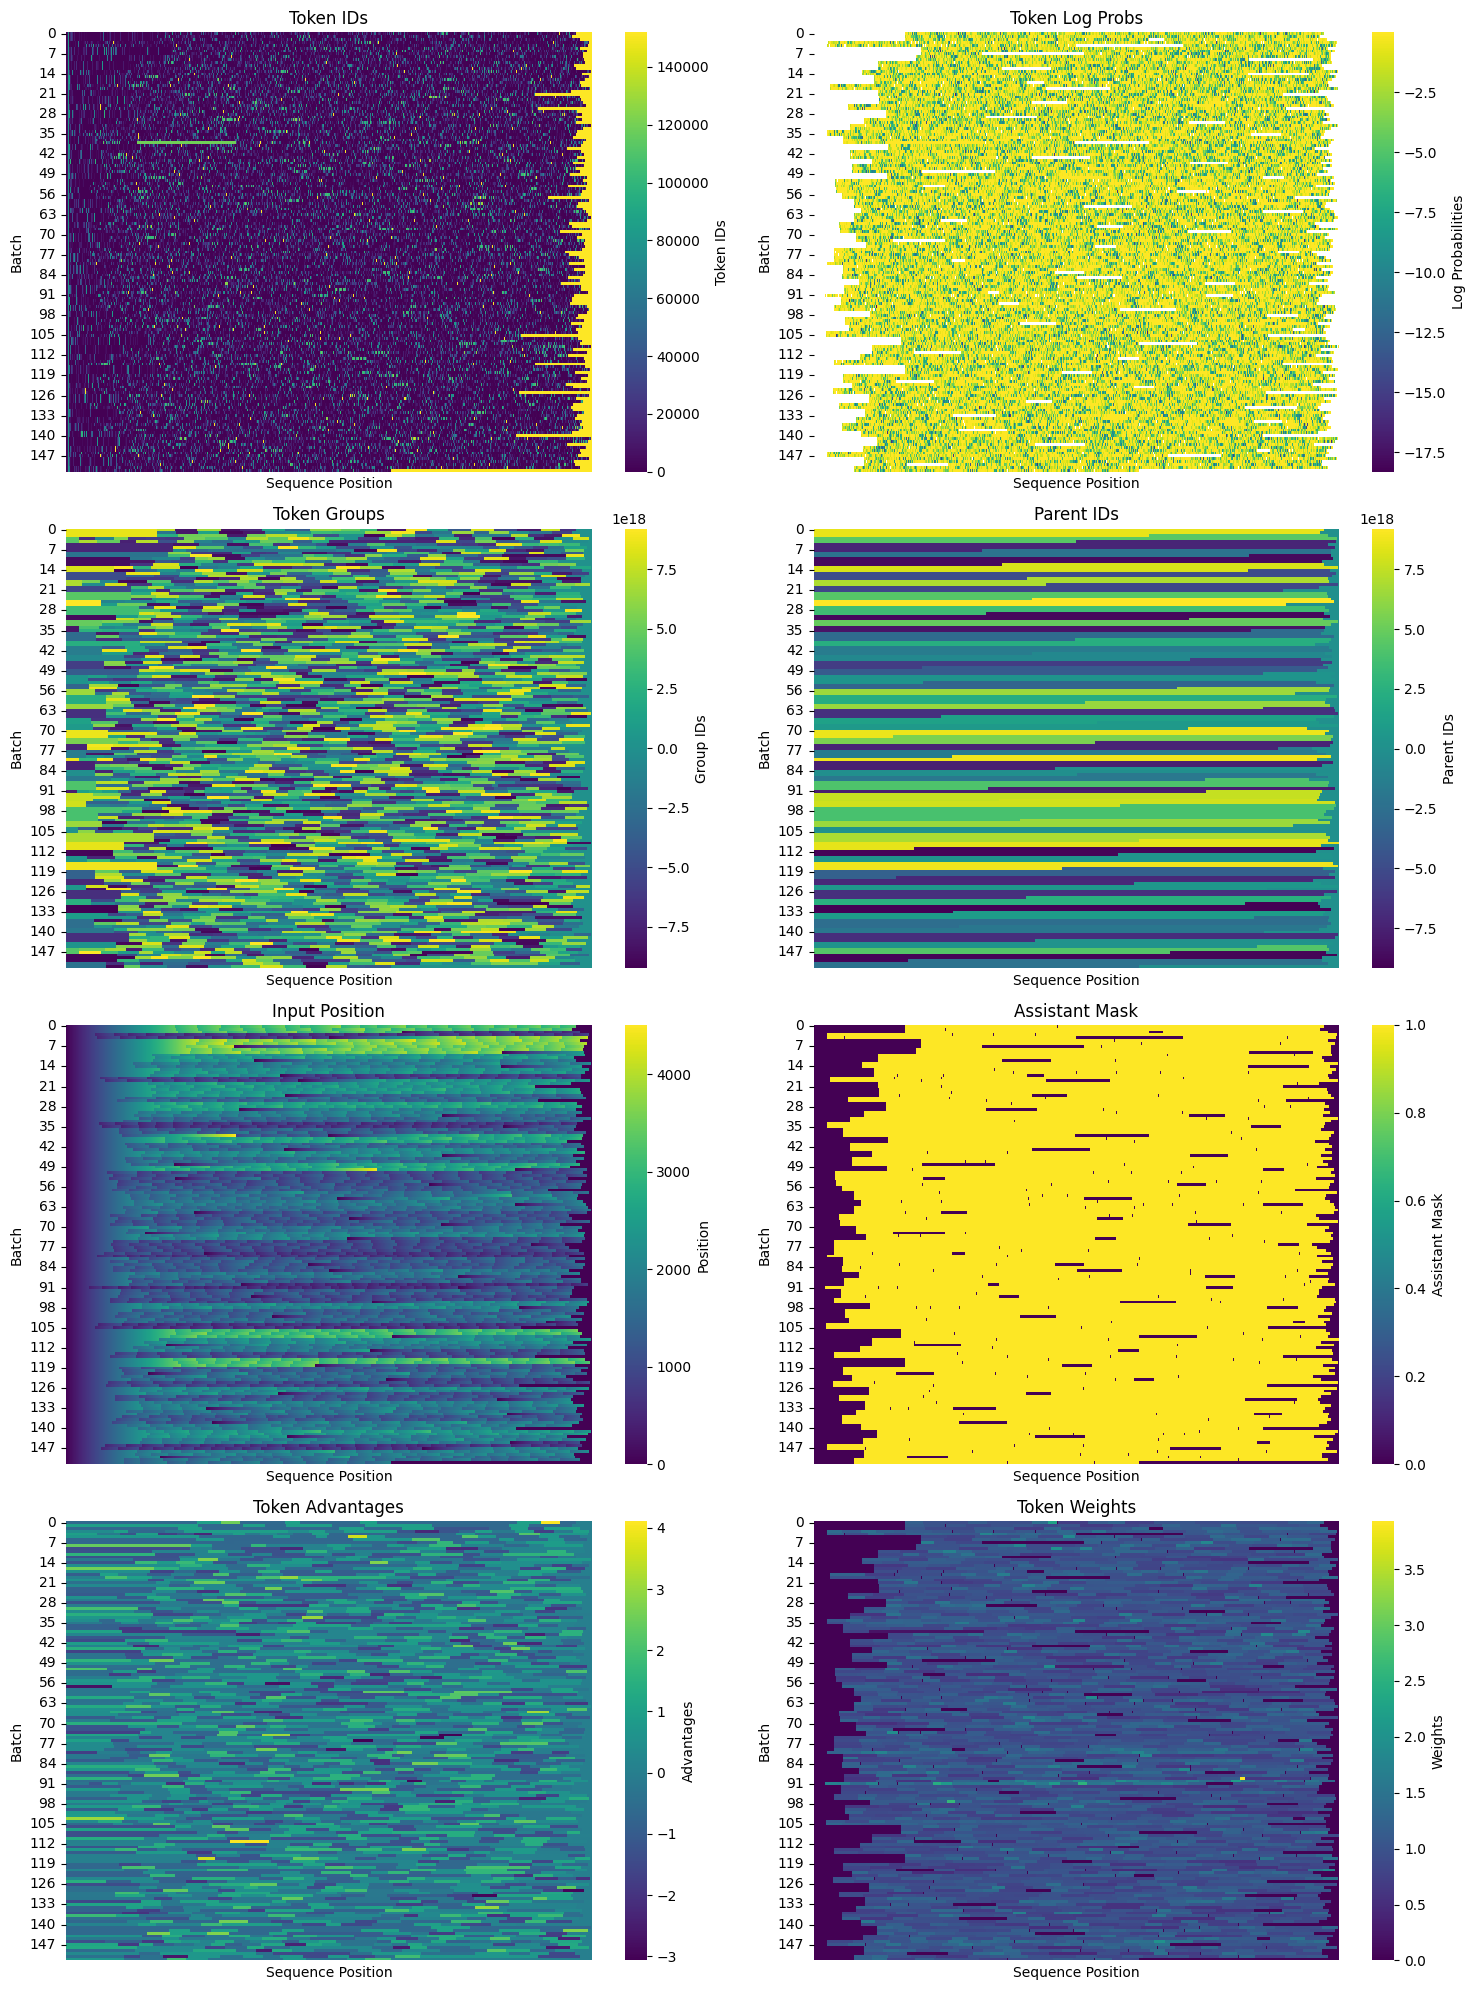

rsyncing /dev/shm/models/030 to /dev/shm/models/030
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/030/config.yaml
Running with torchrun...


W0221 16:05:23.424000 17151 torch/distributed/run.py:793] 
W0221 16:05:23.424000 17151 torch/distributed/run.py:793] *****************************************
W0221 16:05:23.424000 17151 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0221 16:05:23.424000 17151 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/030/0001
  checkpoint_files:
  - hf_model_0001.pt
  - hf_model_0002.pt
  - hf_model_0003.pt
  - hf_m

Writing logs to models/030/logs/log_1740153928.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 24.81 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|38|Loss: -0.0450: 100%|██████████| 38/38 [22:52<00:00, 35.62s/it, entropy=2.21, kl_div=nan, loss=-0.045, policy=-0.000727] INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 17.17 secs
INFO:torchtune.utils._logging:Model checkpoint of size 3.89 GB sav

Saved iteration #2 model files to ./models/030/0002
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/030/0002 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/030/0002 --port=8000 --api-key=default
INFO 02-21 16:29:43 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 16:29:44 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 16:29:44 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/030/0002', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=No

Loading pt checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading pt checkpoint shards:  12% Completed | 1/8 [00:02<00:17,  2.45s/it]
Loading pt checkpoint shards:  25% Completed | 2/8 [00:05<00:15,  2.53s/it]
Loading pt checkpoint shards:  38% Completed | 3/8 [00:07<00:12,  2.56s/it]
Loading pt checkpoint shards:  50% Completed | 4/8 [00:10<00:10,  2.58s/it]
Loading pt checkpoint shards:  62% Completed | 5/8 [00:12<00:07,  2.56s/it]
Loading pt checkpoint shards:  75% Completed | 6/8 [00:15<00:05,  2.58s/it]
Loading pt checkpoint shards:  88% Completed | 7/8 [00:17<00:02,  2.58s/it]


(VllmWorkerProcess pid=20702) INFO 02-21 16:30:17 model_runner.py:1115] Loading model weights took 13.9281 GB


Loading pt checkpoint shards: 100% Completed | 8/8 [00:18<00:00,  2.08s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:18<00:00,  2.37s/it]



INFO 02-21 16:30:17 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=20702) INFO 02-21 16:30:20 worker.py:267] Memory profiling takes 2.10 seconds
(VllmWorkerProcess pid=20702) INFO 02-21 16:30:20 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=20702) INFO 02-21 16:30:20 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-21 16:30:20 worker.py:267] Memory profiling takes 2.35 seconds
INFO 02-21 16:30:20 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-21 16:30:20 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB; PyTorch activation peak memory takes 5.70GiB; the rest of the memory reserved for KV Cache is 53.71GiB.
INFO 02-

INFO:     Started server process [20415]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 16:31:06 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:39016 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [07:10<00:00,  1.39it/s, completion_tokens=590, prompt_tokens=1267, reward=0.284, token_logprobs=1889516]


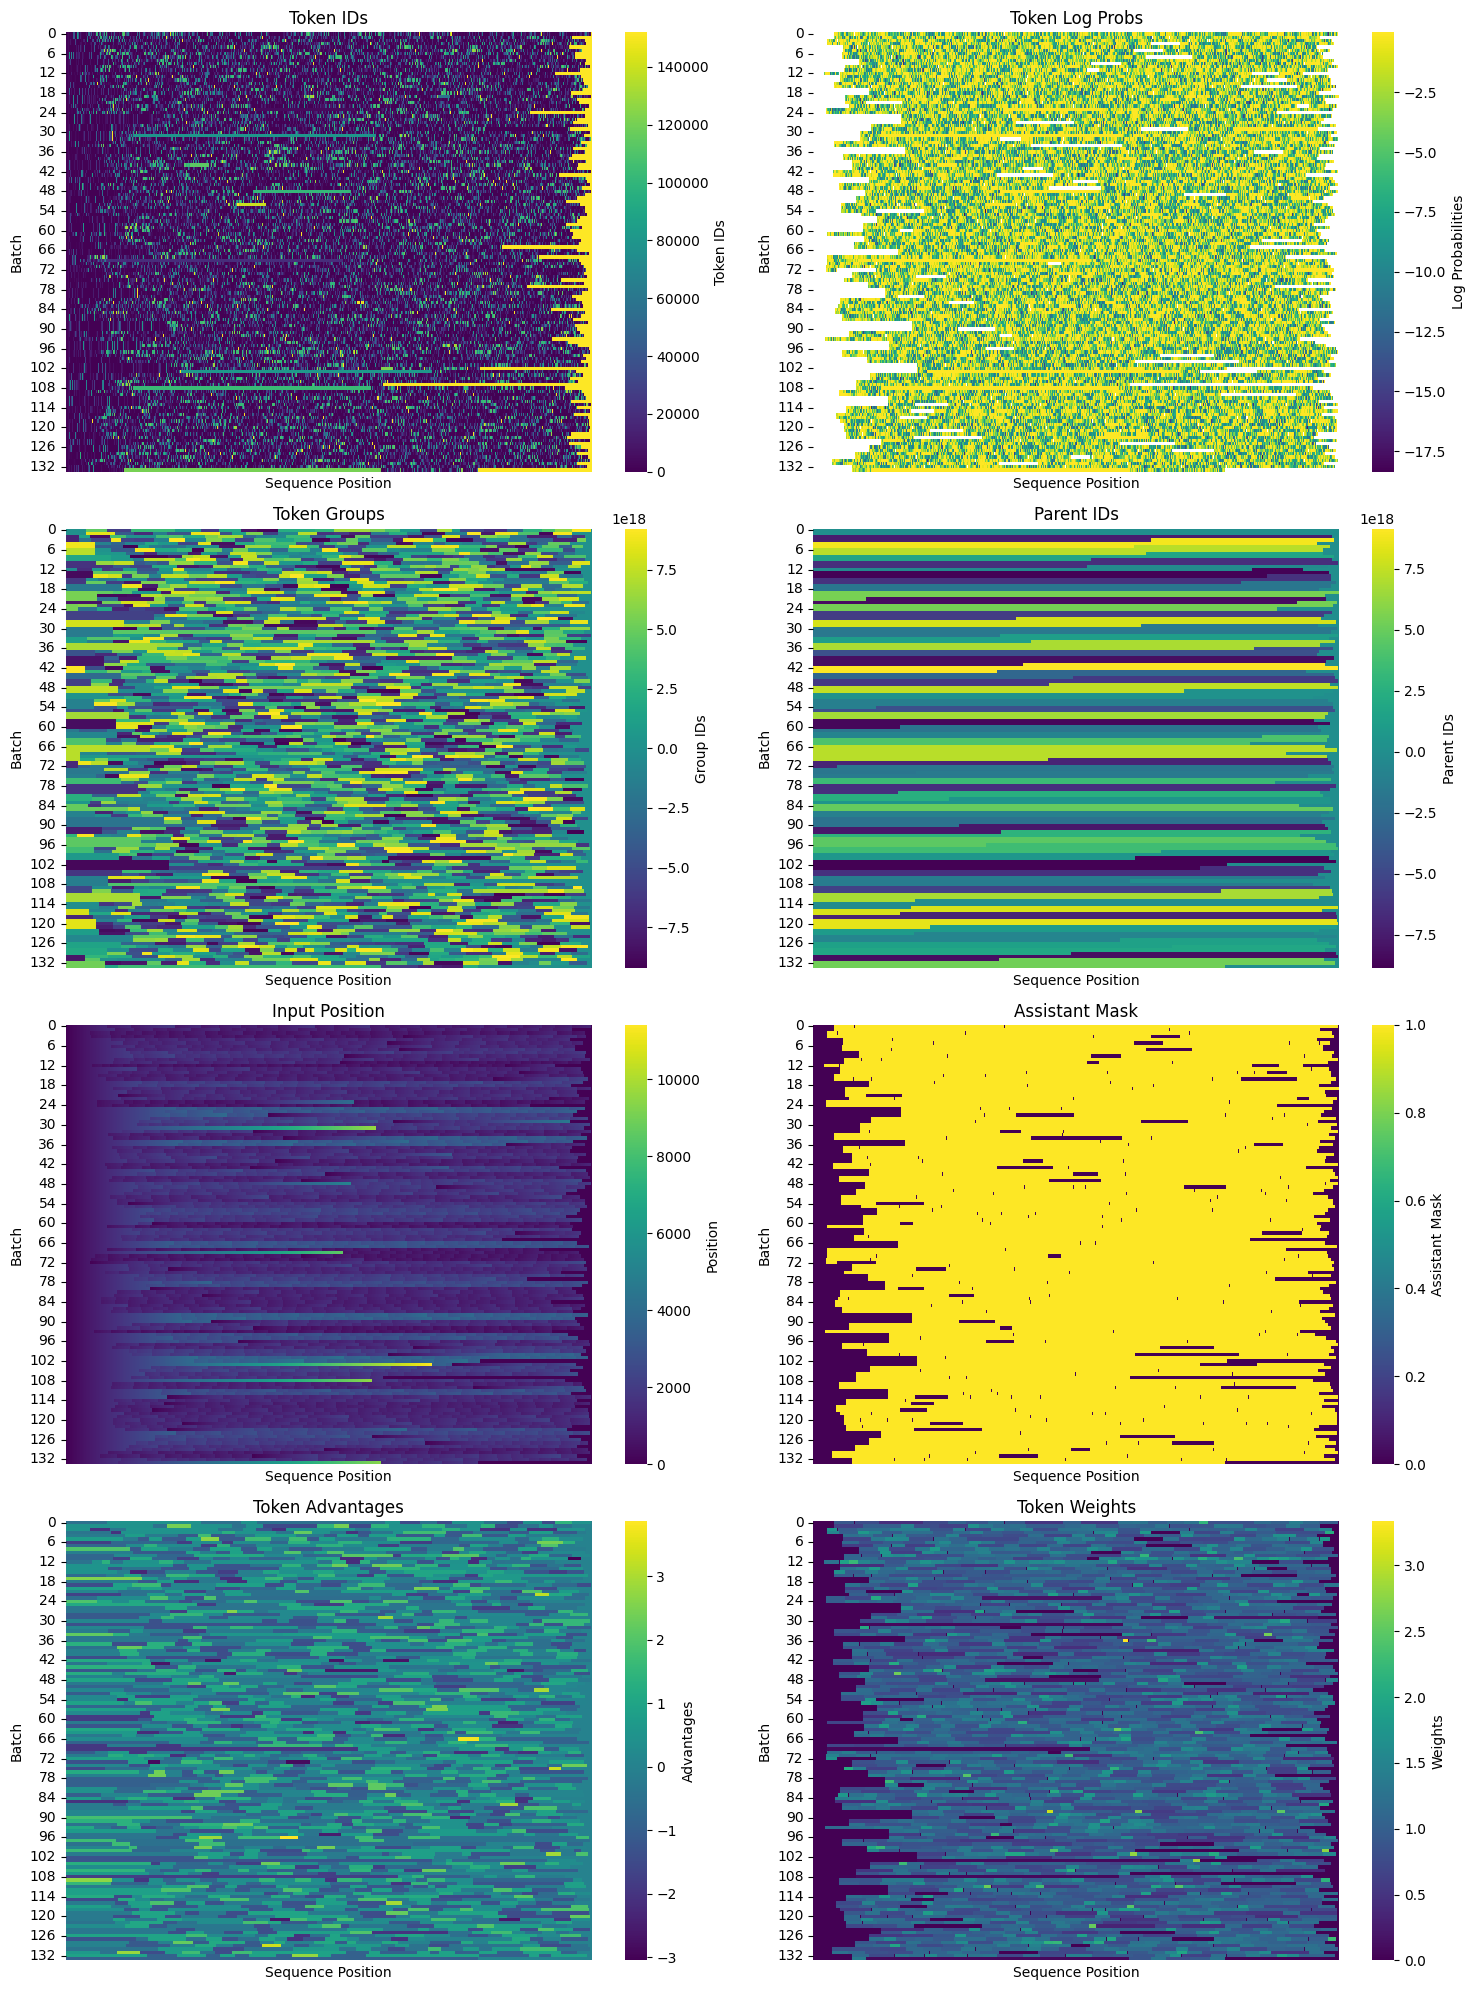

rsyncing /dev/shm/models/030 to /dev/shm/models/030
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/030/config.yaml
Running with torchrun...


W0221 16:38:52.947000 21392 torch/distributed/run.py:793] 
W0221 16:38:52.947000 21392 torch/distributed/run.py:793] *****************************************
W0221 16:38:52.947000 21392 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0221 16:38:52.947000 21392 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/030/0002
  checkpoint_files:
  - hf_model_0001.pt
  - hf_model_0002.pt
  - hf_model_0003.pt
  - hf_model_0004.pt
  - hf_model_0005.pt
  - hf_model_0006.pt
  - hf_model_0007.pt


Writing logs to models/030/logs/log_1740155937.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 24.91 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|33|Loss: -0.0817: 100%|██████████| 33/33 [19:54<00:00, 35.61s/it, entropy=4.23, kl_div=nan, loss=-0.0817, policy=0.00283]  INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 17.26 secs
INFO:torchtune.utils._logging:Model checkpoint of size 3.89 GB sav

Saved iteration #3 model files to ./models/030/0003
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/030/0003 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/030/0003 --port=8000 --api-key=default
INFO 02-21 17:00:15 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 17:00:16 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 17:00:16 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/030/0003', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=No

Loading pt checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading pt checkpoint shards:  12% Completed | 1/8 [00:02<00:17,  2.48s/it]
Loading pt checkpoint shards:  25% Completed | 2/8 [00:05<00:15,  2.54s/it]
Loading pt checkpoint shards:  38% Completed | 3/8 [00:07<00:12,  2.57s/it]
Loading pt checkpoint shards:  50% Completed | 4/8 [00:10<00:10,  2.58s/it]
Loading pt checkpoint shards:  62% Completed | 5/8 [00:12<00:07,  2.60s/it]
Loading pt checkpoint shards:  75% Completed | 6/8 [00:15<00:05,  2.60s/it]
Loading pt checkpoint shards:  88% Completed | 7/8 [00:18<00:02,  2.60s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.09s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.39s/it]



(VllmWorkerProcess pid=24302) INFO 02-21 17:00:50 model_runner.py:1115] Loading model weights took 13.9281 GB
INFO 02-21 17:00:50 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=24302) INFO 02-21 17:00:52 worker.py:267] Memory profiling takes 2.14 seconds
(VllmWorkerProcess pid=24302) INFO 02-21 17:00:52 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=24302) INFO 02-21 17:00:52 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-21 17:00:52 worker.py:267] Memory profiling takes 2.39 seconds
INFO 02-21 17:00:52 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-21 17:00:52 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB; Py

INFO:     Started server process [24013]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 17:01:39 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:39332 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [18:46<00:00,  1.73it/s, completion_tokens=1124, prompt_tokens=1239, reward=0.251, token_logprobs=3.6e+6]
Deleted iteration directory ./models/030/0002


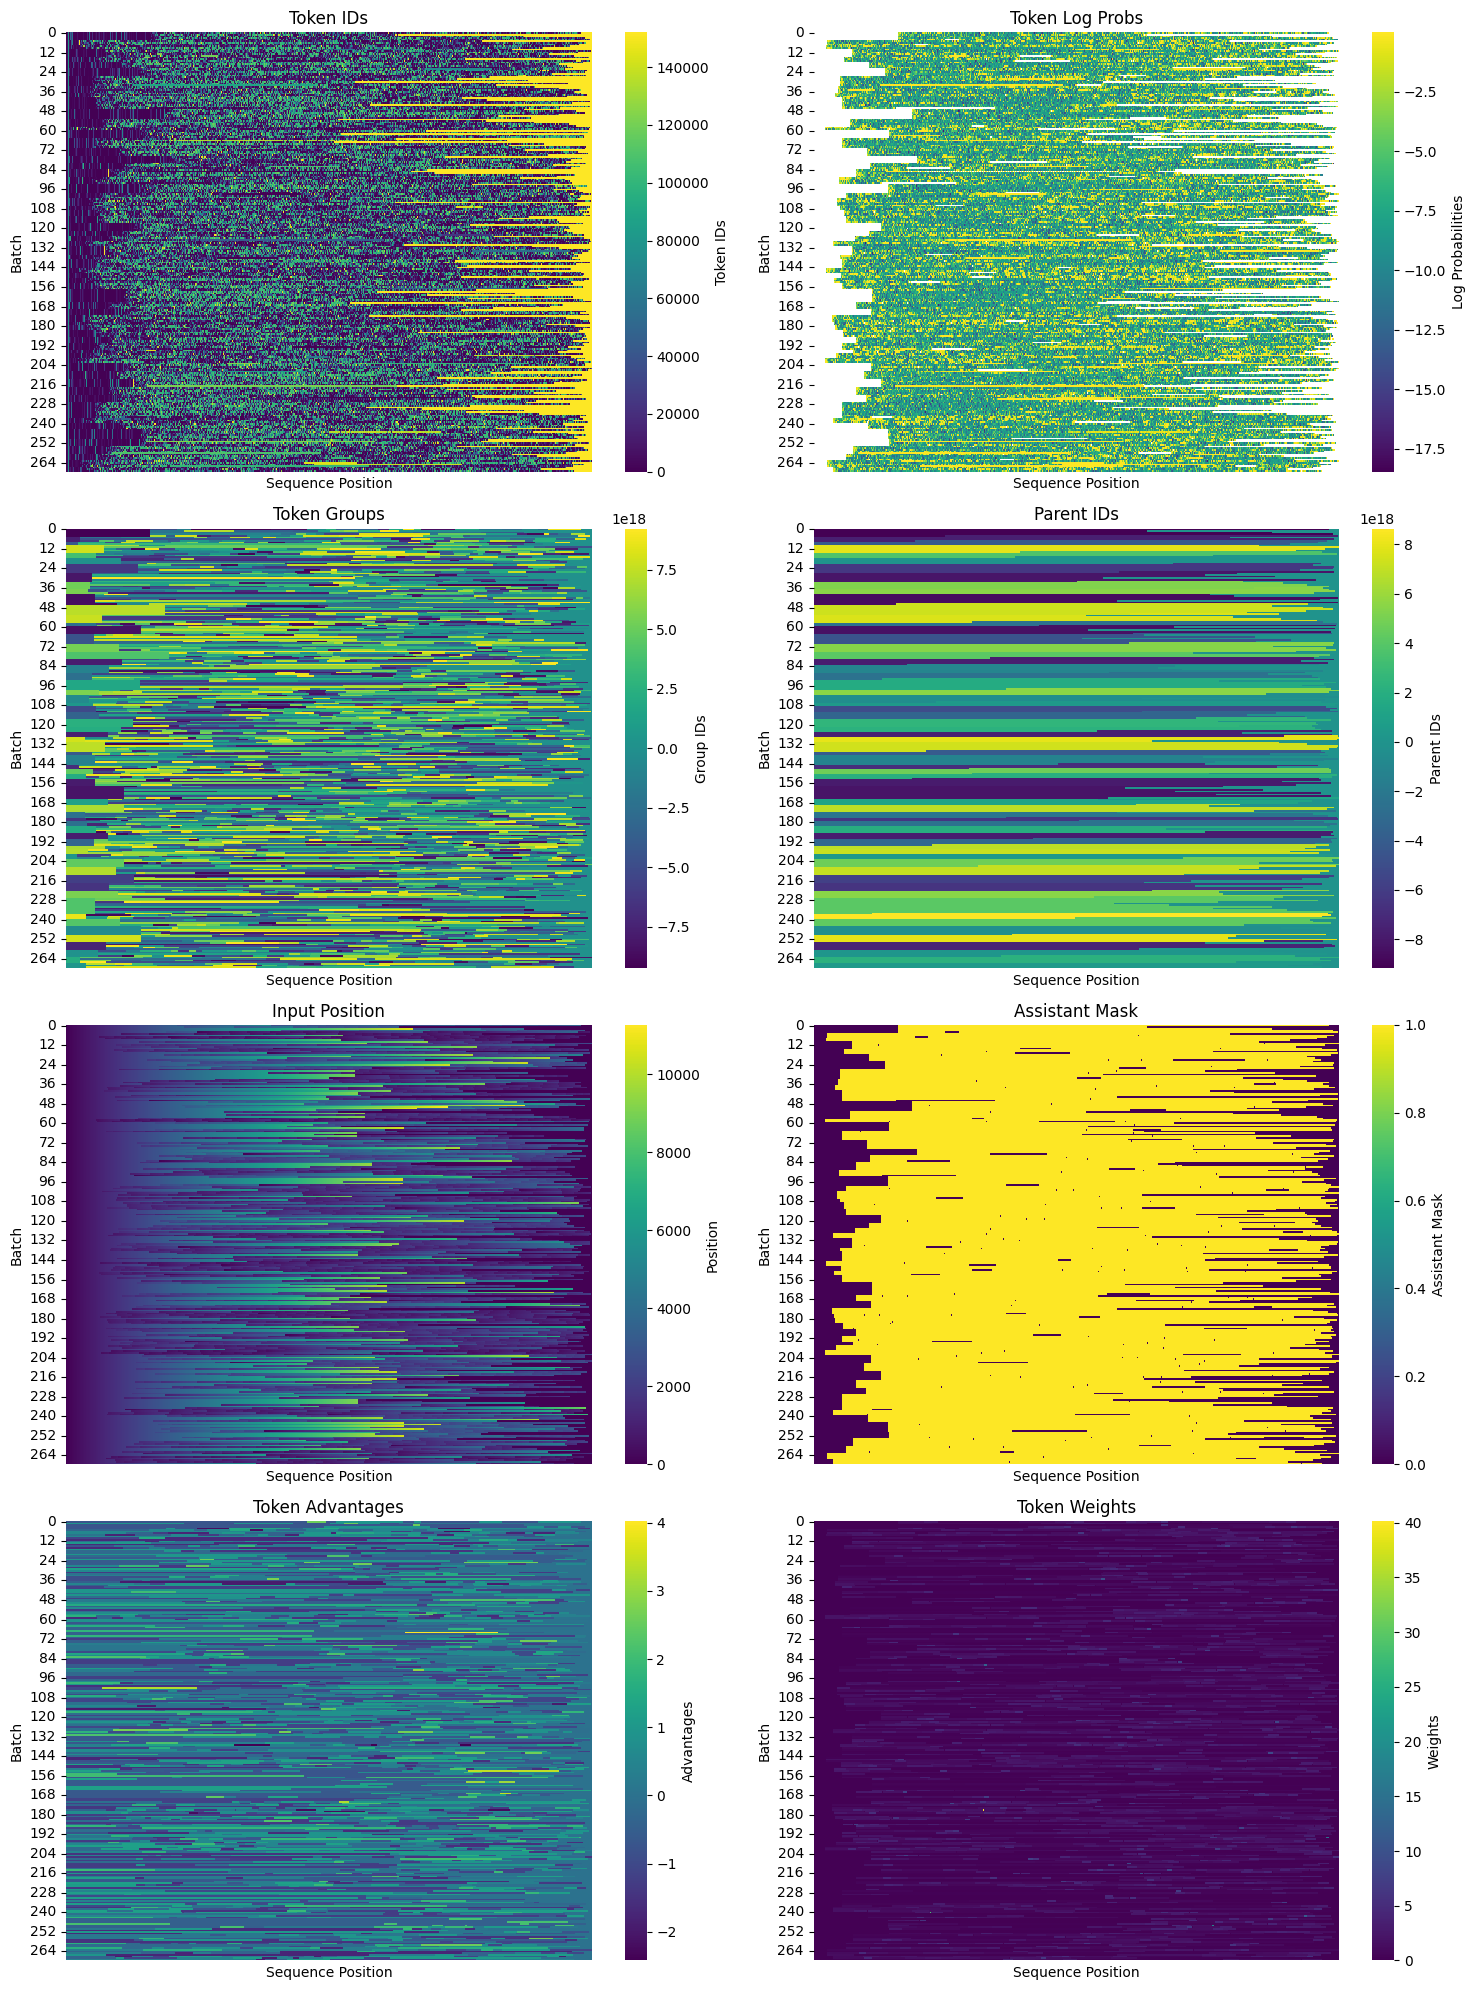

rsyncing /dev/shm/models/030 to /dev/shm/models/030
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/030/config.yaml
Running with torchrun...


W0221 17:21:28.221000 25486 torch/distributed/run.py:793] 
W0221 17:21:28.221000 25486 torch/distributed/run.py:793] *****************************************
W0221 17:21:28.221000 25486 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0221 17:21:28.221000 25486 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/030/0003
  checkpoint_files:
  - hf_model_0001.pt
  - hf_model_0002.pt
  - hf_model_0003.pt
  - hf_m

Writing logs to models/030/logs/log_1740158493.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 24.70 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|67|Loss: -0.1570: 100%|██████████| 67/67 [40:03<00:00, 35.59s/it, entropy=7.24, kl_div=nan, loss=-0.157, policy=-0.0121]  INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 17.29 secs
INFO:torchtune.utils._logging:Model checkpoint of size 3.89 GB save

Saved iteration #4 model files to ./models/030/0004
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/030/0004 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/030/0004 --port=8000 --api-key=default
INFO 02-21 18:02:59 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 18:03:00 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 18:03:00 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/030/0004', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=No

Loading pt checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading pt checkpoint shards:  12% Completed | 1/8 [00:02<00:17,  2.46s/it]
Loading pt checkpoint shards:  25% Completed | 2/8 [00:05<00:15,  2.54s/it]
Loading pt checkpoint shards:  38% Completed | 3/8 [00:07<00:12,  2.56s/it]
Loading pt checkpoint shards:  50% Completed | 4/8 [00:10<00:10,  2.56s/it]
Loading pt checkpoint shards:  62% Completed | 5/8 [00:12<00:07,  2.54s/it]
Loading pt checkpoint shards:  75% Completed | 6/8 [00:15<00:05,  2.56s/it]
Loading pt checkpoint shards:  88% Completed | 7/8 [00:17<00:02,  2.57s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:18<00:00,  2.06s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:18<00:00,  2.36s/it]



(VllmWorkerProcess pid=29695) INFO 02-21 18:03:33 model_runner.py:1115] Loading model weights took 13.9281 GB
INFO 02-21 18:03:33 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=29695) INFO 02-21 18:03:36 worker.py:267] Memory profiling takes 2.14 seconds
(VllmWorkerProcess pid=29695) INFO 02-21 18:03:36 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=29695) INFO 02-21 18:03:36 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-21 18:03:36 worker.py:267] Memory profiling takes 2.38 seconds
INFO 02-21 18:03:36 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-21 18:03:36 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB; Py

INFO:     Started server process [29410]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 18:04:23 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:39958 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train:  82%|████████▏ | 2613/3200 [1:08:10<30:13,  3.09s/it, completion_tokens=2874, prompt_tokens=1164, reward=0.207, token_logprobs=7508813, exceptions=587]
Deleted iteration directory ./models/030/0003


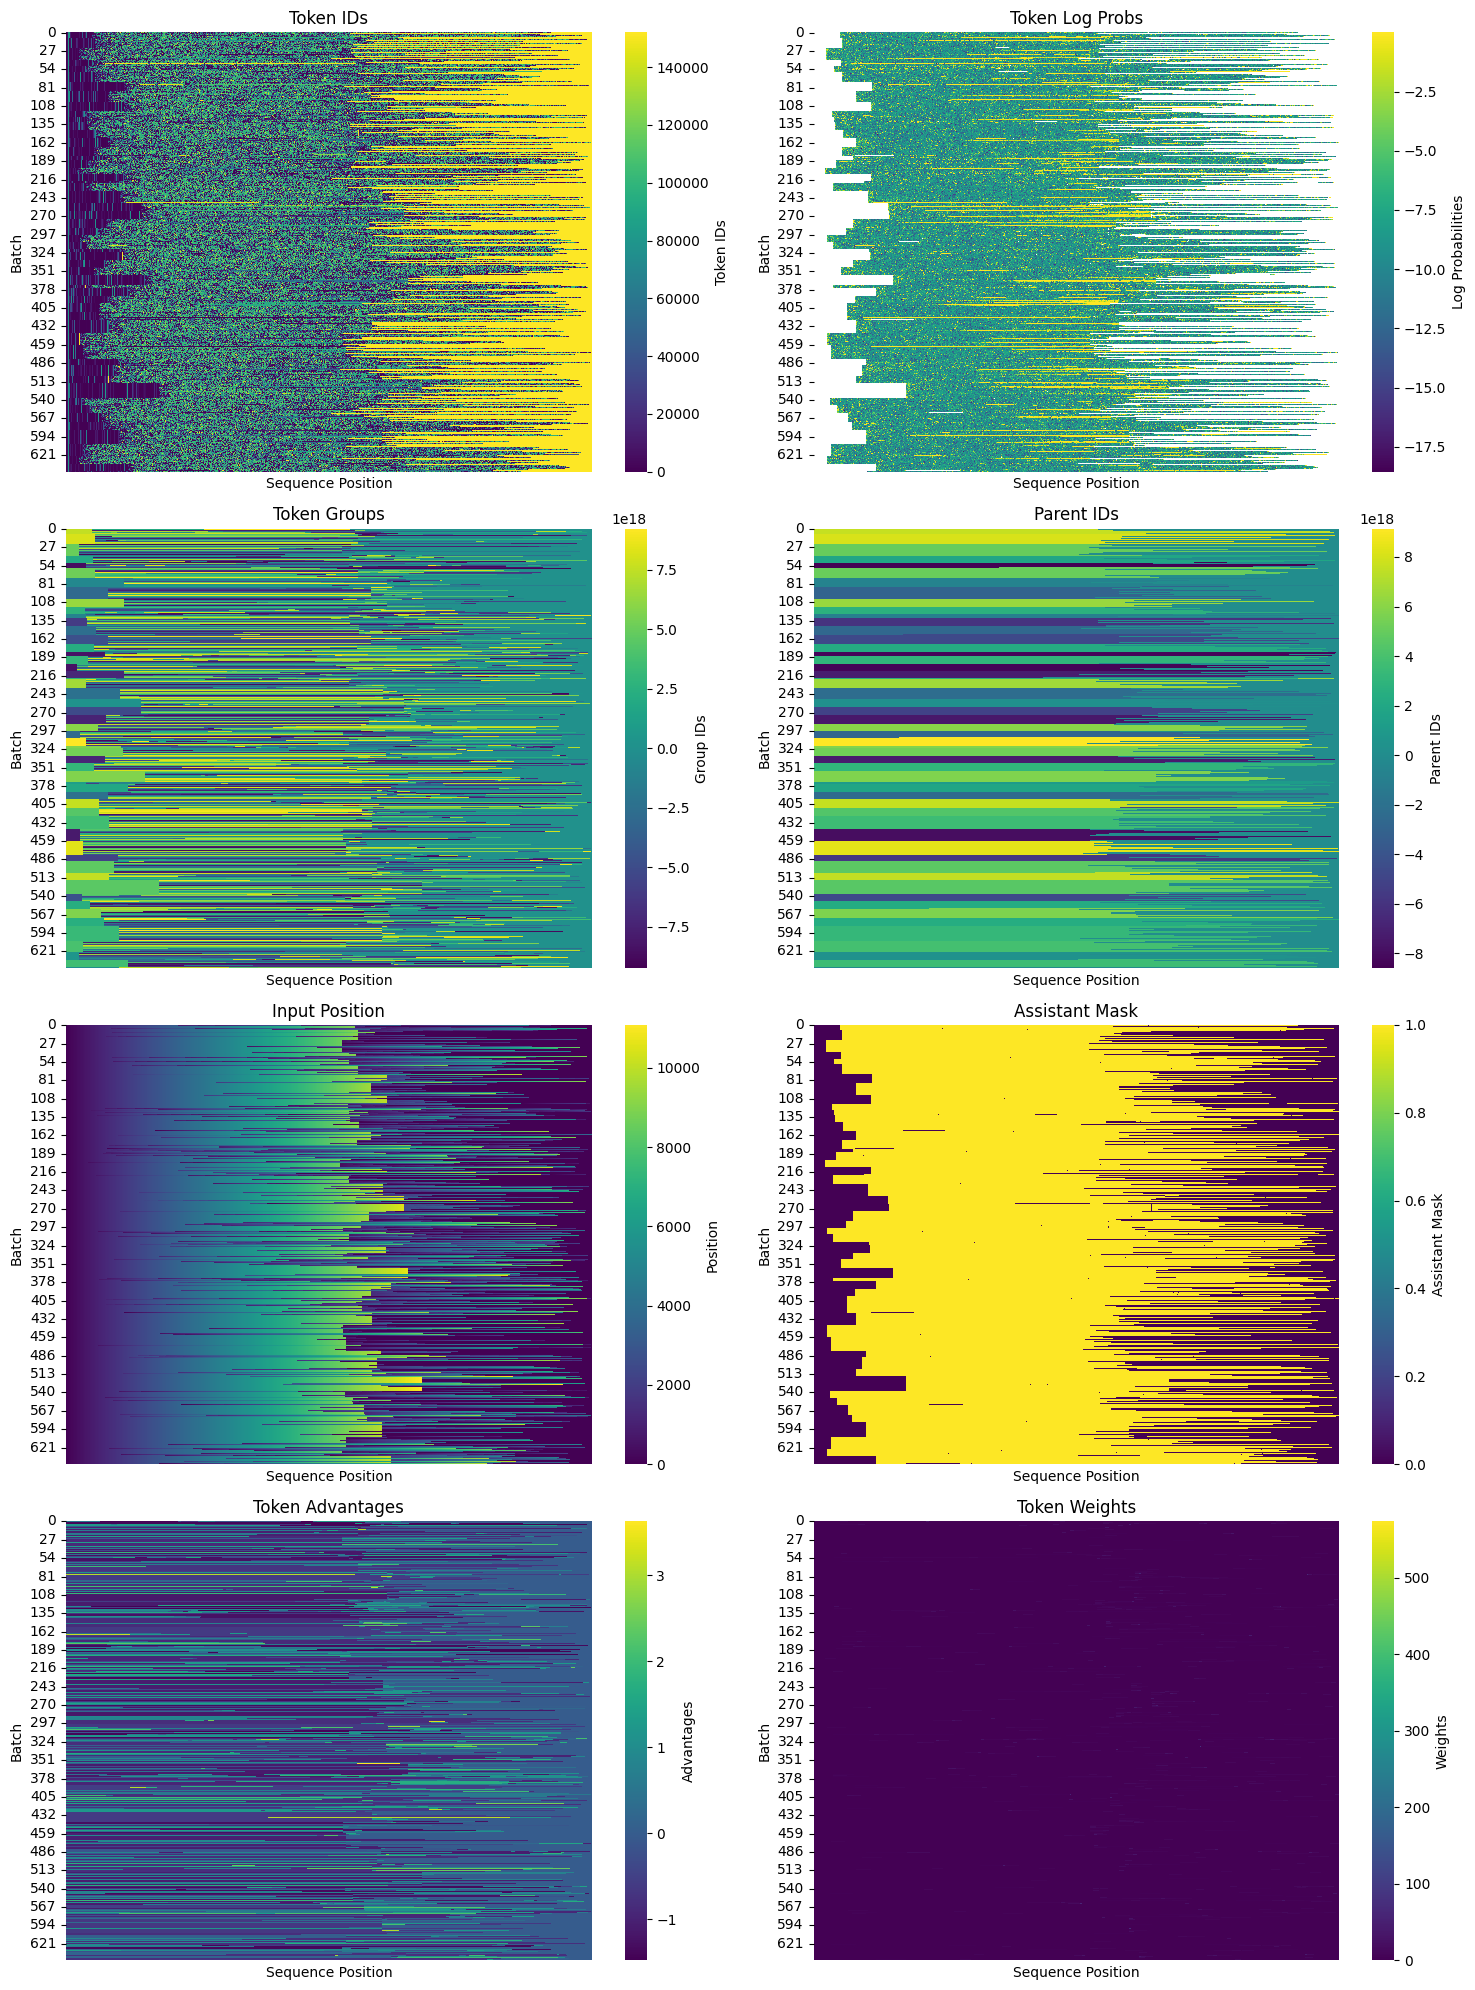

rsyncing /dev/shm/models/030 to /dev/shm/models/030
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/030/config.yaml
Running with torchrun...


W0221 19:14:41.470000 33141 torch/distributed/run.py:793] 
W0221 19:14:41.470000 33141 torch/distributed/run.py:793] *****************************************
W0221 19:14:41.470000 33141 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0221 19:14:41.470000 33141 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/030/0004
  checkpoint_files:
  - hf_model_0001.pt
  - hf_model_0002.pt
  - hf_model_0003.pt
  - hf_model_0004.pt
  - hf_model_0005.pt
  - hf_model_0006.pt
  - hf_model_0007.pt


Writing logs to models/030/logs/log_1740165286.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 24.01 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|161|Loss: -0.0938: 100%|██████████| 161/161 [1:35:37<00:00, 35.52s/it, entropy=4.27, kl_div=nan, loss=-0.0938, policy=-0.00842]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 17.20 secs
INFO:torchtune.utils._logging:Model checkpoint of size 3.89 GB

Saved iteration #5 model files to ./models/030/0005
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/030/0005 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/030/0005 --port=8000 --api-key=default
INFO 02-21 20:51:47 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 20:51:47 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 20:51:47 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/030/0005', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=No

Loading pt checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading pt checkpoint shards:  12% Completed | 1/8 [00:02<00:17,  2.48s/it]
Loading pt checkpoint shards:  25% Completed | 2/8 [00:05<00:15,  2.55s/it]
Loading pt checkpoint shards:  38% Completed | 3/8 [00:07<00:12,  2.57s/it]
Loading pt checkpoint shards:  50% Completed | 4/8 [00:10<00:10,  2.58s/it]
Loading pt checkpoint shards:  62% Completed | 5/8 [00:12<00:07,  2.55s/it]
Loading pt checkpoint shards:  75% Completed | 6/8 [00:15<00:05,  2.54s/it]
Loading pt checkpoint shards:  88% Completed | 7/8 [00:17<00:02,  2.56s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:18<00:00,  2.07s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:18<00:00,  2.36s/it]



(VllmWorkerProcess pid=40883) INFO 02-21 20:52:21 model_runner.py:1115] Loading model weights took 13.9281 GB
INFO 02-21 20:52:21 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=40883) INFO 02-21 20:52:23 worker.py:267] Memory profiling takes 2.29 seconds
(VllmWorkerProcess pid=40883) INFO 02-21 20:52:23 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=40883) INFO 02-21 20:52:23 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-21 20:52:23 worker.py:267] Memory profiling takes 2.38 seconds
INFO 02-21 20:52:23 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-21 20:52:23 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB; Py

INFO:     Started server process [40596]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 20:53:10 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:53386 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

val: 100%|██████████| 128/128 [07:07<00:00, 17.51s/it, completion_tokens=3723, prompt_tokens=1220, reward=0.206, token_logprobs=476511]


CancelledError: 

In [9]:
model_name = get_last_iteration_dir(output_dir) or model.base_model
for i in range(get_iteration(output_dir), num_iterations):
    vllm = await start_vllm(
        model_name,
        max_concurrent_requests=1024,
        env={"VLLM_ALLOW_LONG_MAX_MODEL_LEN": "1"},
        named_arguments=dict(
            block_size=32,
            disable_log_requests=True,
            enable_prefix_caching=True,
            enforce_eager=True,
            gpu_memory_utilization=0.95,
            max_model_len=16384,
            max_num_seqs=1024,
            max_num_batched_tokens=16384,
            num_scheduler_steps=8,
            preemption_mode="swap",
            return_tokens_as_token_ids=True,
            swap_space=80,
            tensor_parallel_size=torch.cuda.device_count(),
        ),
        timeout=180 + 15 * torch.cuda.device_count(),
        verbosity=verbosity,
    )
    semaphore = asyncio.Semaphore(
        int(1.33 * vllm.max_concurrent_tokens / expected_tokens)
    )
    offset = i * stride
    val_results, train_results = await asyncio.gather(
        get_task_results(
            tasks=val_tasks,
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=8,
            n=2,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_tokens=8192,
            ),
            pbar_desc="val",
            semaphore=semaphore,
        ),
        get_task_results(
            tasks=list(islice(cycle(train_tasks), offset, offset + tasks_per_iter)),
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=False,
            n=samples_per_task,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_tokens=8192,
            ),
            pbar_desc="train",
            semaphore=semaphore,
            transform=TaskResultTokenizer(tokenizer),
        ),
    )
    vllm.process.terminate()
    kill_vllm_workers()
    val_stats = val_results.stats
    assert val_stats.grades > 0
    assert val_stats.usages > 0
    wandb_data = {
        "iteration": i,
        "exceptions": val_stats.exceptions + train_results.stats.exceptions,
        "reward": val_stats.total_reward / val_stats.grades,
        "tokens": round(val_stats.completion_tokens / val_stats.usages),
    }
    try:
        wandb_data.update(
            pl.DataFrame(last_tune_log(output_dir)).drop("step").mean().to_dicts()[0]
        )
    except Exception:
        pass
    wandb.log(wandb_data)
    expected_tokens = wandb_data["tokens"]
    try:
        best_iteration = (
            wandb.Api()
            .run(f"{run.entity}/{run.project}/{run.id}")
            .history()
            .sort_values(by="reward")["iteration"]
            .iloc[-1]
        )
        clear_iteration_dirs(output_dir, [best_iteration, i])
    except Exception:
        pass
    # see ./logs/rsync.log for output
    asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/"))
    tokenized_results = [
        result
        for results in train_results
        for result in results
        if result.advantage != 0
    ]
    packed_tensors = packed_tensors_from_tokenized_results(
        tokenized_results,
        seq_len=seq_len,
        pad_token_id=tokenizer.pad_token_id,  # type: ignore
    )
    if verbosity == 2:
        plot_packed_tensors(packed_tensors)
    else:
        print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")
    optimizer_config = ComponentConfig(
        model.tune_optimizer,
        lr=lr,
        betas=betas,
        weight_decay=weight_decay,
    )
    if model.tune_optimizer == "torch.optim.AdamW":
        optimizer_config.fused = True
    model_name = await tune(
        base_model=model.base_model,
        output_dir=output_dir,
        packed_tensors=packed_tensors,
        model=model.tune_model,
        model_type=model.tune_model_type,
        config=TuneRecipeConfig(
            optimizer=optimizer_config,
            loss=ComponentConfig(
                GRPO,
                clip_epsilon=clip_epsilon,
                entropy_coef=entropy_coef,
                kl_coef=kl_coef,
                tanh=tanh,
            ),
            shuffle=True,
            batch_size=model.tune_max_batch_tokens // seq_len,
            fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
            enable_activation_checkpointing=True,
            enable_activation_offloading=True,
            custom_sharded_layers=["tok_embeddings", "output"],
            num_output_chunks=2,
        ),
        verbosity=verbosity,
    )
wandb.finish()

In [ ]:
model_name = get_last_iteration_dir(output_dir) or model.base_model
for i in range(get_iteration(output_dir), num_iterations):
    vllm = await start_vllm(
        model_name,
        max_concurrent_requests=1024,
        env={"VLLM_ALLOW_LONG_MAX_MODEL_LEN": "1"},
        named_arguments=dict(
            block_size=32,
            disable_log_requests=True,
            enable_prefix_caching=True,
            enforce_eager=True,
            gpu_memory_utilization=0.95,
            max_model_len=16384,
            max_num_seqs=1024,
            max_num_batched_tokens=16384,
            num_scheduler_steps=8,
            preemption_mode="swap",
            return_tokens_as_token_ids=True,
            swap_space=80,
            tensor_parallel_size=torch.cuda.device_count(),
        ),
        timeout=180 + 15 * torch.cuda.device_count(),
        verbosity=verbosity,
    )
    semaphore = asyncio.Semaphore(
        int(1.33 * vllm.max_concurrent_tokens / expected_tokens)
    )
    offset = i * stride
    val_results, train_results = await asyncio.gather(
        get_task_results(
            tasks=val_tasks,
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=8,
            n=2,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_tokens=8192,
            ),
            pbar_desc="val",
            semaphore=semaphore,
        ),
        get_task_results(
            tasks=list(islice(cycle(train_tasks), offset, offset + tasks_per_iter)),
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=False,
            n=samples_per_task,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_tokens=8192,
            ),
            pbar_desc="train",
            semaphore=semaphore,
            transform=TaskResultTokenizer(tokenizer),
        ),
    )
    vllm.process.terminate()
    kill_vllm_workers()
    val_stats = val_results.stats
    assert val_stats.grades > 0
    assert val_stats.usages > 0
    wandb_data = {
        "iteration": i,
        "exceptions": val_stats.exceptions + train_results.stats.exceptions,
        "reward": val_stats.total_reward / val_stats.grades,
        "tokens": round(val_stats.completion_tokens / val_stats.usages),
    }
    try:
        wandb_data.update(
            pl.DataFrame(last_tune_log(output_dir)).drop("step").mean().to_dicts()[0]
        )
    except Exception:
        pass
    wandb.log(wandb_data)
    expected_tokens = wandb_data["tokens"]
    try:
        best_iteration = (
            wandb.Api()
            .run(f"{run.entity}/{run.project}/{run.id}")
            .history()
            .sort_values(by="reward")["iteration"]
            .iloc[-1]
        )
        clear_iteration_dirs(output_dir, [best_iteration, i])
    except Exception:
        pass
    # see ./logs/rsync.log for output
    asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/"))
    tokenized_results = [
        result
        for results in train_results
        for result in results
        if result.advantage != 0
    ]
    packed_tensors = packed_tensors_from_tokenized_results(
        tokenized_results,
        seq_len=seq_len,
        pad_token_id=tokenizer.pad_token_id,  # type: ignore
    )
    if verbosity == 2:
        plot_packed_tensors(packed_tensors)
    else:
        print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")
    optimizer_config = ComponentConfig(
        model.tune_optimizer,
        lr=lr,
        betas=betas,
        weight_decay=weight_decay,
    )
    if model.tune_optimizer == "torch.optim.AdamW":
        optimizer_config.fused = True
    model_name = await tune(
        base_model=model.base_model,
        output_dir=output_dir,
        packed_tensors=packed_tensors,
        model=model.tune_model,
        model_type=model.tune_model_type,
        config=TuneRecipeConfig(
            optimizer=optimizer_config,
            loss=ComponentConfig(
                GRPO,
                clip_epsilon=clip_epsilon,
                entropy_coef=entropy_coef,
                kl_coef=kl_coef,
                tanh=tanh,
            ),
            shuffle=True,
            batch_size=model.tune_max_batch_tokens // seq_len,
            fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
            enable_activation_checkpointing=True,
            enable_activation_offloading=True,
            custom_sharded_layers=["tok_embeddings", "output"],
            num_output_chunks=2,
        ),
        verbosity=verbosity,
    )
wandb.finish()

$ vllm serve /home/ubuntu/sky_workdir/experiments/models/027/0005 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/027/0005 --port=8000 --api-key=default
INFO 02-21 05:49:10 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 05:49:10 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 05:49:10 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/027/0005', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_role

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.48it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:03<00:03,  1.98s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:06<00:02,  2.39s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.54s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.30s/it]



INFO 02-21 05:49:28 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 05:49:29 worker.py:267] Memory profiling takes 0.66 seconds
INFO 02-21 05:49:29 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 05:49:29 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.22GiB.
INFO 02-21 05:49:29 executor_base.py:110] # CUDA blocks: 14137, # CPU blocks: 20480
INFO 02-21 05:49:29 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.61x
INFO 02-21 05:50:11 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 42.46 seconds
INFO 02-21 05:50:11 api_server.py:756] Using supplied chat template:
INFO 02-21 05:50:11 api_server.py:756] None
INFO 02-21 05:50:11 launcher.py:21] Available routes are:
INFO 02-21 05:50:11 launcher.py:29] Route: /

INFO:     Started server process [20070]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 05:50:12 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:58728 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]